# 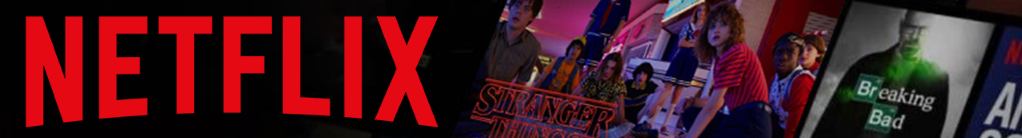 **Aplicación de un Modelo ARIMA para el análisis de la cotización de Netflix Inc.**


---

Autor   : ***Luis Enrique Cayatopa-Rivera*** | ORCID [https://orcid.org/0000-0002-6359-2125](https://orcid.org/0000-0002-6359-2125) | Curso: Técnicas para el manejo de Series de Tiempo | Programa: Doctorado en Economía | Universidad Nacional Mayor de San Marcos | Periodo : 2024-II


---


In [22]:
#@title **Video tutorial de la resolución del caso aplicativo**
%%html
<iframe width="1000" height="500" src="https://www.youtube.com/embed/M0-oJbQZrxk?si=dNxgC_WTPz6-C8CE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

***Conexión a los datos de Yahoo Finance***

A fin de iniciar el análisis econométrico, en primer, lugar se procede a conectar los datos de https://es.finance.yahoo.com/quote/NFLX/ mediante la API de Yahoo Finance.

In [ ]:
# Descarga de librerías de Python
!pip install yfinance plotly warnings statsmodels pmdarima

In [ ]:
!pip install pmdarima

In [3]:
# Conexión de datos
import yfinance as yf
#data = yf.download("NFLX", period="max")
data = yf.download("NFLX", start='2015-01-01', end='2024-08-30')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,49.151428,50.331429,48.731430,49.848572,49.848572,13475000
2015-01-05,49.258572,49.258572,47.147144,47.311428,47.311428,18165000
2015-01-06,47.347141,47.639999,45.661430,46.501431,46.501431,16037700
2015-01-07,47.347141,47.421429,46.271427,46.742859,46.742859,9849700
2015-01-08,47.119999,47.835712,46.478573,47.779999,47.779999,9601900
...,...,...,...,...,...,...
2024-08-23,694.130005,696.070007,678.630005,686.729980,686.729980,2354500
2024-08-26,687.260010,690.590027,681.640015,688.440002,688.440002,1354200
2024-08-27,688.530029,707.890015,686.919983,695.719971,695.719971,3164900


***Análisis gráfico de la serie histórica***

En este acápite se presenta en primer lugar, un análisis gráfico dinámico de la cotización de Netflix. Asimismo, se divide la serie de tiempo en dos grupos: Un primer grupo de entrenamiento (en el cual se desarrollará el Modelo ARIMA), y un segundo grupo de validación de los resultados del modelo.

In [4]:
#@title Ploteo de gráfico dinámico de la cotización histórica
import plotly.express as px
fig = px.line(data, x=data.index, y=['Adj Close'],
              title='Cotización histórica de Netflix Inc. al 2024', template='plotly')
fig.update_xaxes(
    title_text=None,
    ticklabelposition="inside top",
    rangeslider_visible=True,
    rangeselector=dict(
        x=0,
        xanchor="auto",
        y=1,
        yanchor="bottom",
        buttons=list([
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(count=15, label="15y", step="year", stepmode="todate"),
            dict(step="all")
        ]),
        font=dict(
            color="#111111",
            size=14,
            family="Arial",
            ),
        visible=True,
    )
)
fig.update_yaxes(
    title_text='USD'
)
fig.show();

Fechas train : 2015-01-02 00:00:00 --- 2024-05-31 00:00:00  (n=2369)
Fechas test  : 2024-05-31 00:00:00 --- 2024-08-29 00:00:00  (n=63)
 



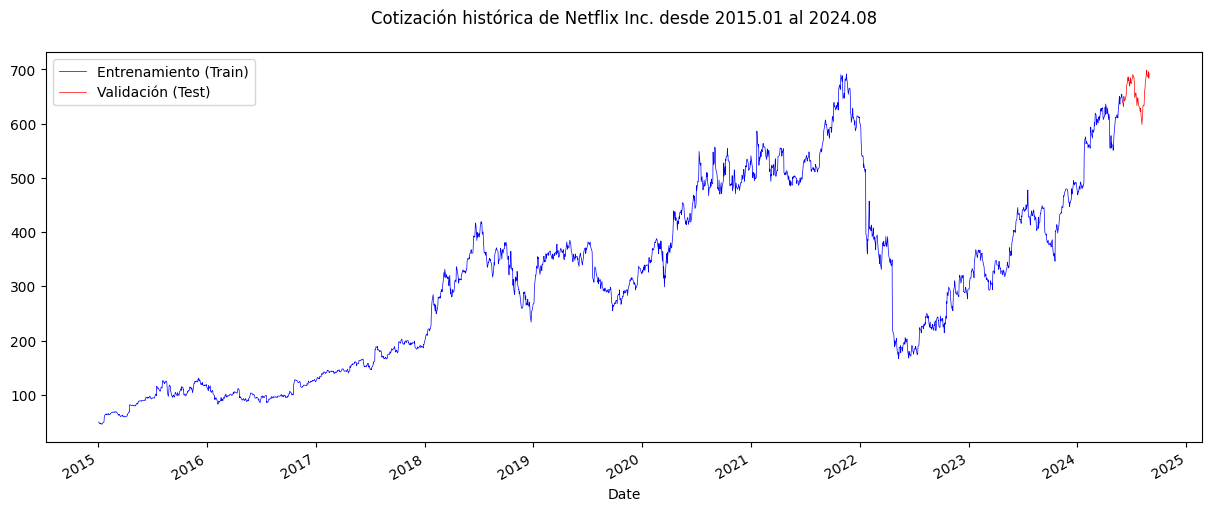

In [5]:
#@title Ploteo de grupo de datos de "Entrenamiento" y "Validación"

fin_train = '2024-05-31 00:00:00'
print(
    f"Fechas train : {data.index.min()} --- {data.loc[:fin_train].index.max()}  "
    f"(n={len(data.loc[:fin_train])})"
)
print(
    f"Fechas test  : {data.loc[fin_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[fin_train:])})"
)
datos_train = data['Adj Close'].loc[:fin_train]
datos_test  = data['Adj Close'].loc[fin_train:]

# Graficar los grupos de datos para "Entrenamiento" y "Validación"
import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(12, 5), layout='constrained')
datos_train.plot(ax=ax, label='Entrenamiento (Train)', linewidth=0.5, color='blue')
datos_test.plot(ax=ax, label='Validación (Test)', linewidth=0.5, color='red')
#ax.axvline(x=fin_train, color='gray', linestyle='--')
ax.set_title('Cotización histórica de Netflix Inc. desde 2015.01 al 2024.08\n')
ax.legend()
print(" \n");

##**Desarrollo de la Metodología Box-Jenkins**

A continuación, se detallan los pasos a seguir para el análisis unicuacional de la serie de tiempo, mediante la Metodología [Box-Jenkins (1976)](https://archive.org/details/timeseriesanalys0000boxg_p2r1/page/n5/mode/2up) .

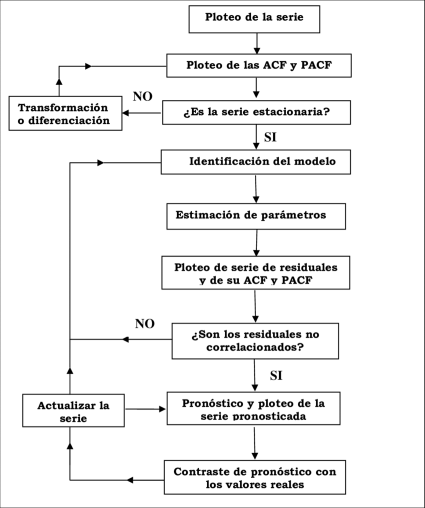

Test estacionariedad serie original
---------------------------------------------------------------------
ADF Statistic: -1.91867833309177, p-value: 0.6449358116280329

Test estacionariedad para serie diferenciada (order=1)
---------------------------------------------------------------------
ADF Statistic: -10.46031957251575, p-value: 1.3644296430118685e-18
 



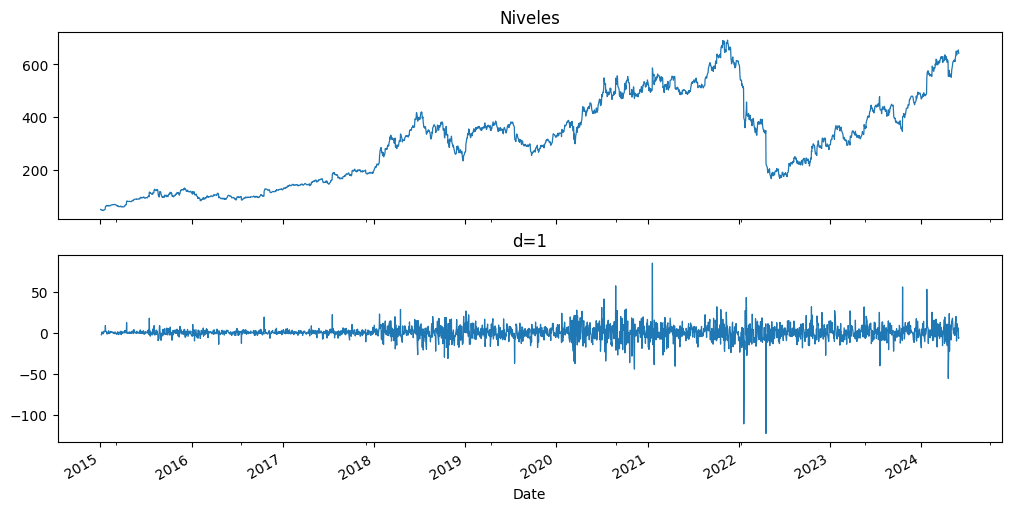

In [6]:
#@title **Paso 1:** *Análisis de estacionariedad*

import warnings
warnings.filterwarnings("ignore")
datos_diff_1 = datos_train.diff().dropna()

from statsmodels.tsa.stattools import adfuller
print('Test estacionariedad serie original')
print('---------------------------------------------------------------------')
adfuller_result = adfuller(datos_train, regression='ct')
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('---------------------------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

warnings.filterwarnings("default")

# Gráfico series | Funciones de autocorrelación y autocorrelación parcial

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), layout='constrained', sharex=True)
datos_train.plot(ax=axs[0], title='Niveles',linewidth=0.9)
datos_diff_1.plot(ax=axs[1], title='d=1',linewidth=0.9)
print(" \n");

**Conclusión:** La serie de tiempo en niveles de la cotización e Netflix no es estacionaria. En tanto, en **I=d(1)** la serie ***sí presenta un comportamiento estacionario***.

''

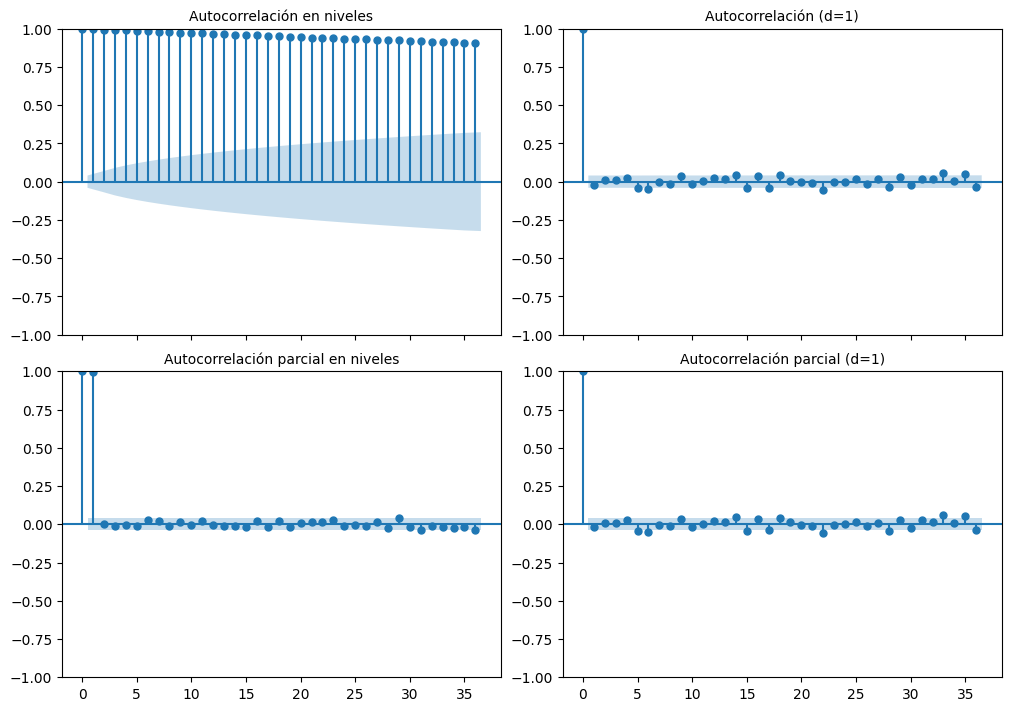

In [8]:
#@title **Paso 2:** *Análisis de Autocorrelación y autocorrelación parcial*

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7), layout='constrained', sharex=True)
plot_acf(datos_train, ax=axs[0,0], lags=36, alpha=0.05)
axs[0,0].set_title('Autocorrelación en niveles', fontsize=10)
plot_acf(datos_diff_1, ax=axs[0,1], lags=36, alpha=0.05)
axs[0,1].set_title('Autocorrelación (d=1)', fontsize=10)
plot_pacf(datos_train, ax=axs[1,0], lags=36, alpha=0.05)
axs[1,0].set_title('Autocorrelación parcial en niveles', fontsize=10)
plot_pacf(datos_diff_1, ax=axs[1,1], lags=36, alpha=0.05)
axs[1,1].set_title('Autocorrelación parcial (d=1)', fontsize=10);
;

**Conclusión:** Del análisis gráfico de la Autocorrelación Parcial en d=1 se puede estimar un **p(máx)=9**, y a partir del análisis de Autocorrelación en d=1 se estima un **q(máx)=9**.

In [10]:
#@title **Paso 3:** *Optimización de parámetros mediante el algoritmo de auto_arima*

import pmdarima as pm
smodel = pm.auto_arima(datos_train, start_p=1, start_q=1,
                      test='adf',       # Usar adftest para encontrar la 'd' óptima
                      max_p=9, max_q=9, # Máximo valor de p y q
                      m=0,              # Frecuencia de la serie
                      d=1,              # Dejar que el modelo determine 'd'
                      seasonal=False,   # Si la serie presenta estacionalidad=True
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(smodel.summary());

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17205.224, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17202.531, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17203.499, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17203.517, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17202.301, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.336 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2369
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8600.150
Date:                Sun, 20 Oct 2024   AIC                          17202.301
Time:                        12:43:29   BIC                          17208.071
Sample:                             0   HQIC                         17204.401
                               - 2369                                  

In [11]:
#@title **Paso 4:** *Determinación del Modelo ARIMA*

warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo = SARIMAX(endog = datos_train, order = (0, 1, 0), seasonal_order = (0, 0, 0, 0))

modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default");
modelo_res.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2369
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8600.150
Date:                Sun, 20 Oct 2024   AIC                          17202.301
Time:                        12:43:33   BIC                          17208.071
Sample:                             0   HQIC                         17204.401
                               - 2369                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        83.5772      0.616    135.617      0.000      82.369      84.785
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):             85212.33
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):              12.00   Skew:                            -1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

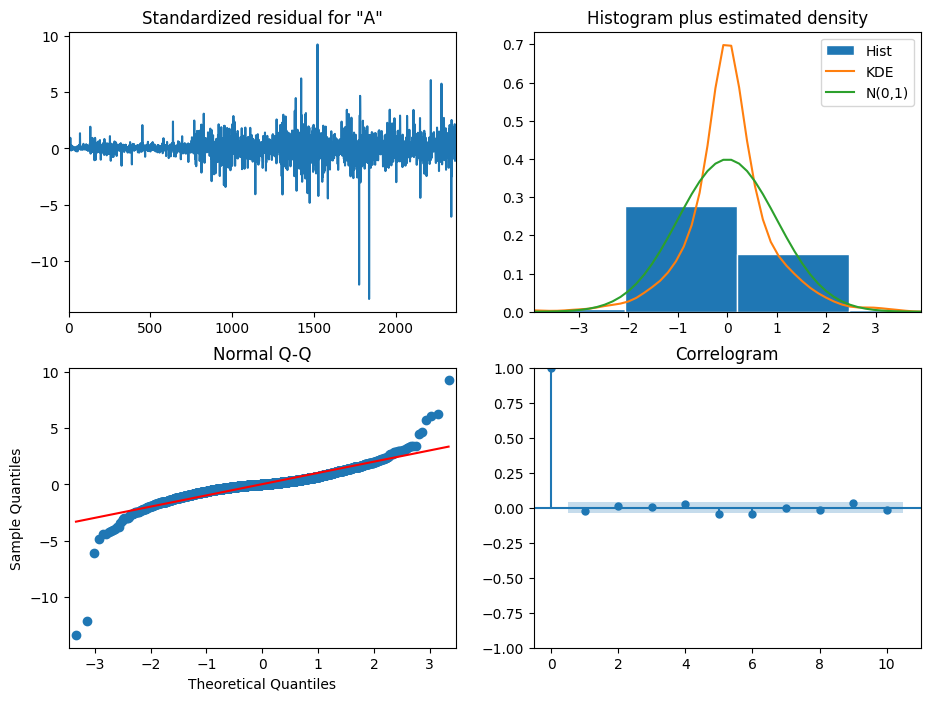

In [12]:
#@title **Paso 5:** *Ajuste y diagnóstico de los residuos del Modelo*

modelo_res.plot_diagnostics(figsize=(11, 8))
plt.show();



---



Fuentes: [GitHub](https://github.com/williewheeler/time-series-demos/blob/master/arima/arima-python.ipynb)